In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [5]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA Available:  True


In [6]:

model = Net().to(device)
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available:  True


In [8]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=128, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8436754.55it/s]                            


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129421.18it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


1654784it [00:00, 2133435.45it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


8192it [00:00, 49391.85it/s]            


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
epoch_num = 20
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Remember a line with model.to(device)?
        # It moves a model to a GPU and PyTorch expects that
        # input data also will be on the GPU where the model resides
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        
        # Calculate the error between model predictins and actual labels
        loss = criterion(outputs, labels)
        
        # Initiate backward propagation
        loss.backward()
        
        # Update weights
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[Epoch {epoch + 1}: batch {i + 1}] loss: {running_loss / 200}')
            running_loss = 0.0

print('Finished Training')

[Epoch 1: batch 200] loss: 2.299173150062561
[Epoch 1: batch 400] loss: 2.284377715587616
[Epoch 2: batch 200] loss: 2.1932198822498323
[Epoch 2: batch 400] loss: 1.7623821431398392
[Epoch 3: batch 200] loss: 1.0342556673288346
[Epoch 3: batch 400] loss: 0.8270441868901253
[Epoch 4: batch 200] loss: 0.6952814441919327
[Epoch 4: batch 400] loss: 0.6274984340369701
[Epoch 5: batch 200] loss: 0.5731029719114303
[Epoch 5: batch 400] loss: 0.54249627918005
[Epoch 6: batch 200] loss: 0.5104681788384915
[Epoch 6: batch 400] loss: 0.4785847717523575
[Epoch 7: batch 200] loss: 0.4594589614868164
[Epoch 7: batch 400] loss: 0.436381723806262
[Epoch 8: batch 200] loss: 0.42054355807602406
[Epoch 8: batch 400] loss: 0.4160282389074564
[Epoch 9: batch 200] loss: 0.3977762738615274
[Epoch 9: batch 400] loss: 0.39164834447205066
[Epoch 10: batch 200] loss: 0.38323703907430173
[Epoch 10: batch 400] loss: 0.3671681468188763
[Epoch 11: batch 200] loss: 0.3560740649700165
[Epoch 11: batch 400] loss: 0.351

In [0]:
data_test = datasets.MNIST('./mnist',
                           train=False,
                           download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                           ]))

test_loader = torch.utils.data.DataLoader(data_test, batch_size=256)

In [12]:
# Prevent training
model.eval()

total_correct = 0
avg_loss = 0.0

for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
   
    output = model(inputs)
    avg_loss += criterion(output, labels).sum()
    
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad.
    # It detaches the output from the computational graph.
    # So no gradient will be backpropagated along this variable.
    pred = output.detach().max(1)[1]
    total_correct += pred.eq(labels.view_as(pred)).sum()

avg_loss /= len(data_test)
avg_loss = avg_loss.detach().cpu().item()
accuracy = float(total_correct) / len(data_test)
print(f'Test Avg. Loss: {avg_loss}, Accuracy: {accuracy}')

Test Avg. Loss: 0.000401645025704056, Accuracy: 0.9685


In [0]:
# Save model state for re-use
my_awesome_model = 'my-lenet.pth'
torch.save(model.state_dict(), my_awesome_model)

In [0]:
# FGSM attack code
def fgsm_attack(image, eps, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + eps * sign_data_grad
    
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    # Return the perturbed image
    return perturbed_image

In [0]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist',
                   train=False,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=1, shuffle=True)

In [0]:
def test( model, device, test_loader, epsilon, adv_target, i, iterative=False):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        
        if iterative:
            num_iterations = 10
        else:
            num_iterations = 1
        
        # If iterative is True, then do attack 10 times to each sample  
        for _ in range(num_iterations):
            # Set requires_grad attribute of tensor. Important for Attack
            data.requires_grad = True
            
            # Forward pass the data through the model
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

            # If the initial prediction is wrong, dont bother attacking, just move on
            if init_pred.item() != target.item():
                continue

            # Calculate the loss - Negative Log Likehood
            # Loosely explained at https://medium.com/deeplearningmadeeasy/negative-log-likelihood-6bd79b55d8b6
            loss = -F.nll_loss(output, adv_target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = data.grad.data

            # Call FGSM Attack
            data = fgsm_attack(data, epsilon, data_grad)
            
            # Remove newly generated adversarial data from PyTorch graph
            # Thats important not to create loop dependencies for the gradient when we will iterate
            data = data.detach()
            
        perturbed_data = data

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 10):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        elif final_pred.item() == adv_target.item():
            # Save some adv examples for visualization later
            if len(adv_examples) < 10:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Class: {} Epsilon: {}\tTest Accuracy = {} / {} = {}".format(i, epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [169]:
examples = []
accuracy = []
for i in range(10):
  adv_target = torch.tensor([i]).to(device)
  # Epsilon 0 means no attack at all
  epsilons = [.1, .15, .2]

  # Run test for each epsilon
  for eps in epsilons:
      acc, ex = test(model, device, test_loader, eps, adv_target, i)
      accuracy.append(acc)
      examples.append(ex)

Class: 0 Epsilon: 0.1	Test Accuracy = 9116 / 10000 = 0.9116
Class: 0 Epsilon: 0.15	Test Accuracy = 8159 / 10000 = 0.8159
Class: 0 Epsilon: 0.2	Test Accuracy = 6492 / 10000 = 0.6492
Class: 1 Epsilon: 0.1	Test Accuracy = 9161 / 10000 = 0.9161
Class: 1 Epsilon: 0.15	Test Accuracy = 8200 / 10000 = 0.82
Class: 1 Epsilon: 0.2	Test Accuracy = 6506 / 10000 = 0.6506
Class: 2 Epsilon: 0.1	Test Accuracy = 9062 / 10000 = 0.9062
Class: 2 Epsilon: 0.15	Test Accuracy = 8066 / 10000 = 0.8066
Class: 2 Epsilon: 0.2	Test Accuracy = 6096 / 10000 = 0.6096
Class: 3 Epsilon: 0.1	Test Accuracy = 8911 / 10000 = 0.8911
Class: 3 Epsilon: 0.15	Test Accuracy = 7698 / 10000 = 0.7698
Class: 3 Epsilon: 0.2	Test Accuracy = 5529 / 10000 = 0.5529
Class: 4 Epsilon: 0.1	Test Accuracy = 9085 / 10000 = 0.9085
Class: 4 Epsilon: 0.15	Test Accuracy = 8268 / 10000 = 0.8268
Class: 4 Epsilon: 0.2	Test Accuracy = 6953 / 10000 = 0.6953
Class: 5 Epsilon: 0.1	Test Accuracy = 8933 / 10000 = 0.8933
Class: 5 Epsilon: 0.15	Test Accuracy 

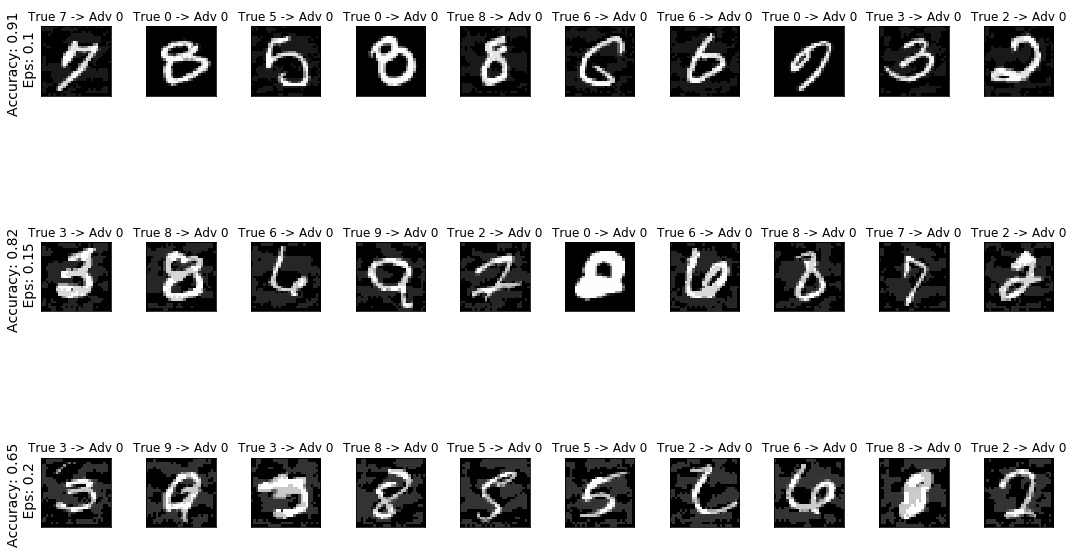

In [170]:
# Plot several examples of adversarial samples at each epsilon
epsilons = [.1, .15, .2, .1, .15, .2, .1, .15, .2, .1, .15, .2, .1, .15, .2, .1, .15, .2, .1, .15, .2, .1, .15, .2, .1, .15, .2, .1, .15, .2]
cnt = 0
plt.figure(figsize=(15,90))
for i in range(3):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

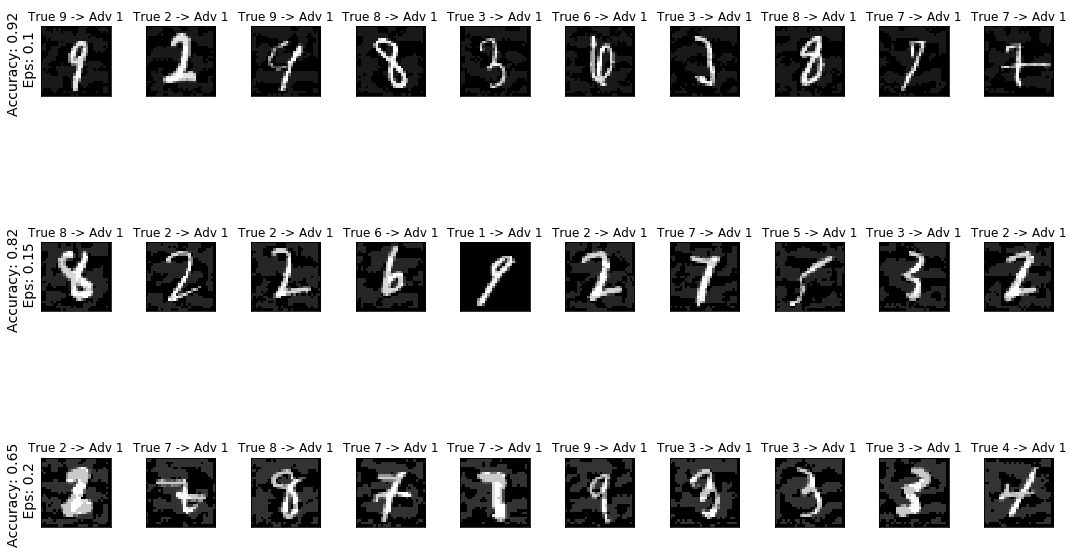

In [171]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(15,90))
for i in range(3, 6):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

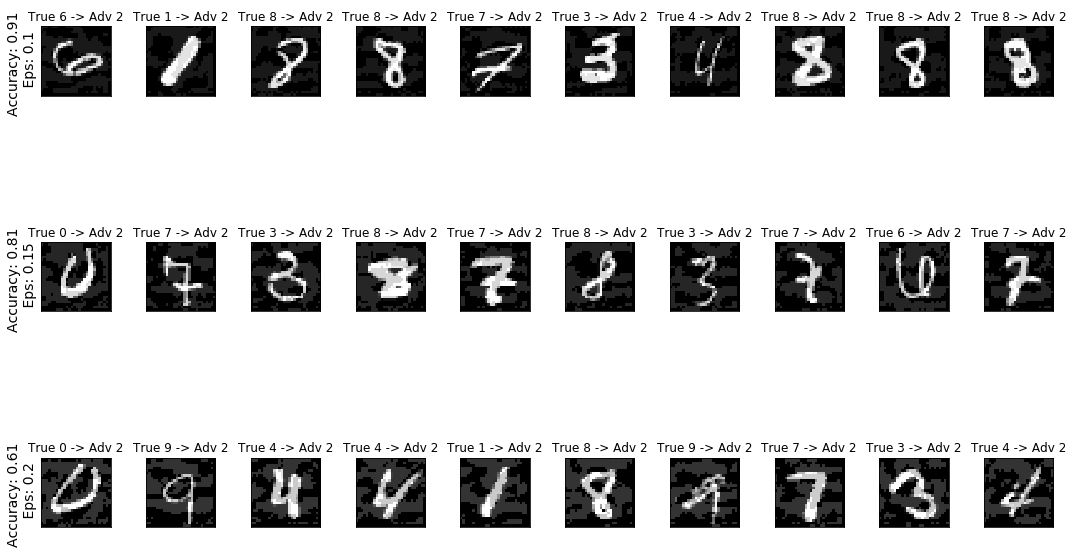

In [172]:
cnt = 0
plt.figure(figsize=(15,90))
for i in range(6, 9):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

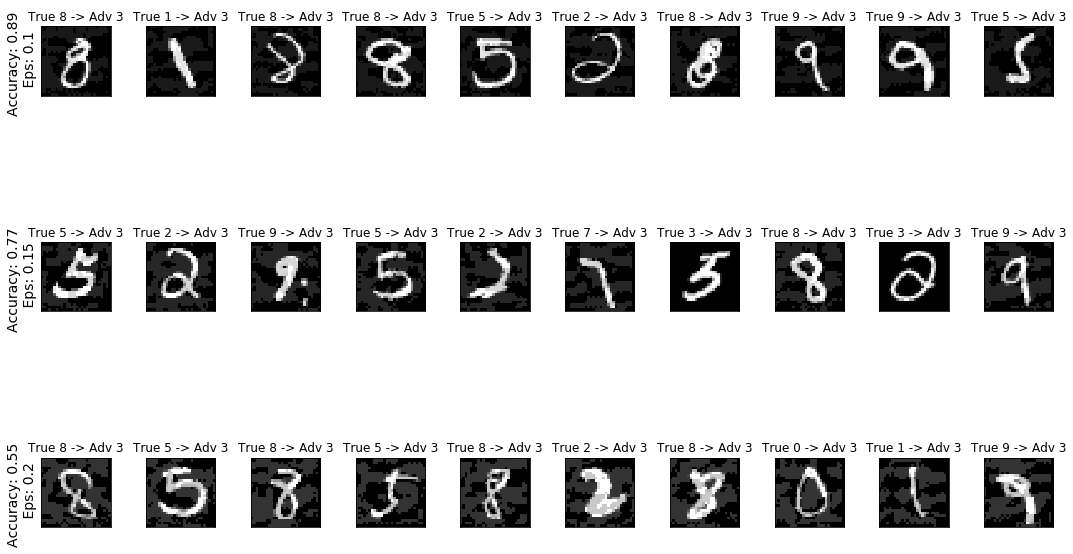

In [173]:
cnt = 0
plt.figure(figsize=(15,90))
for i in range(9, 12):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

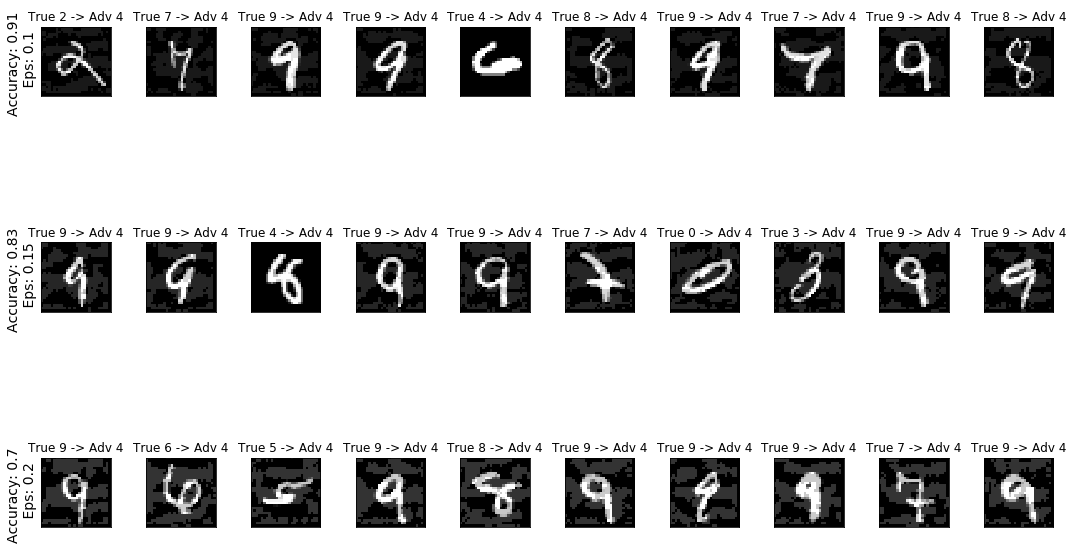

In [174]:
cnt = 0
plt.figure(figsize=(15,90))
for i in range(12, 15):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

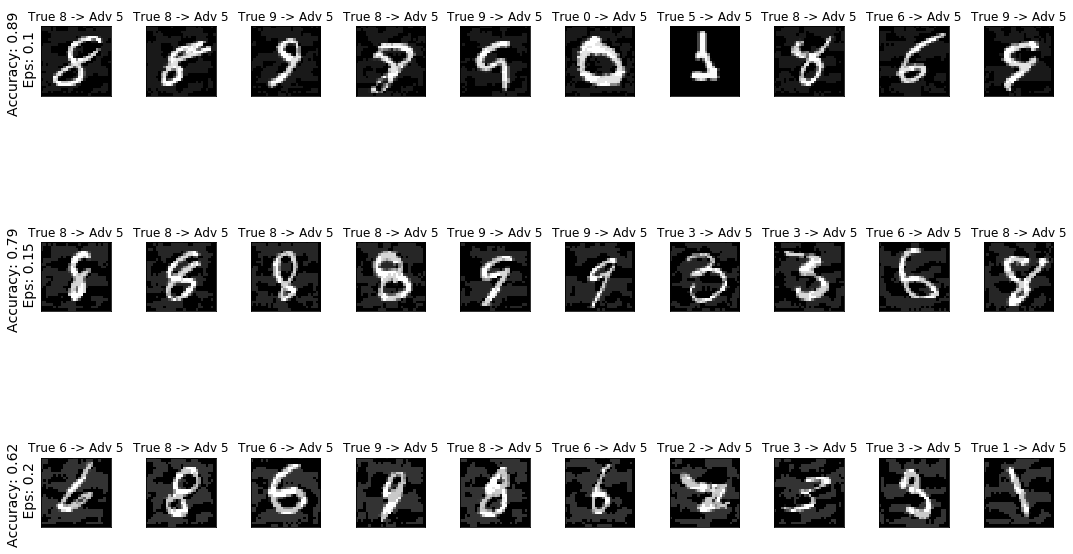

In [175]:
cnt = 0
plt.figure(figsize=(15,90))
for i in range(15, 18):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

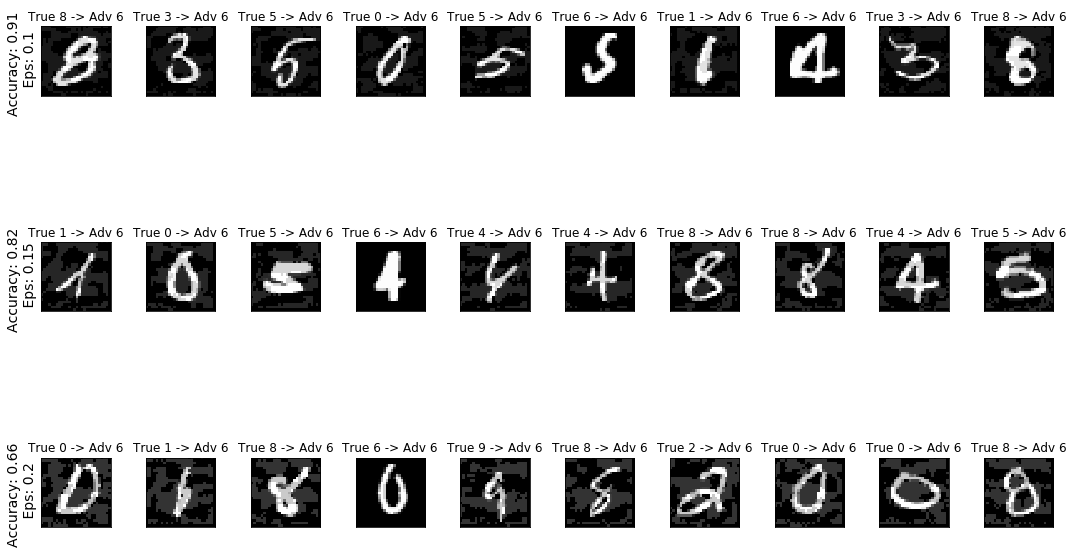

In [176]:
cnt = 0
plt.figure(figsize=(15,90))
for i in range(18, 21):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

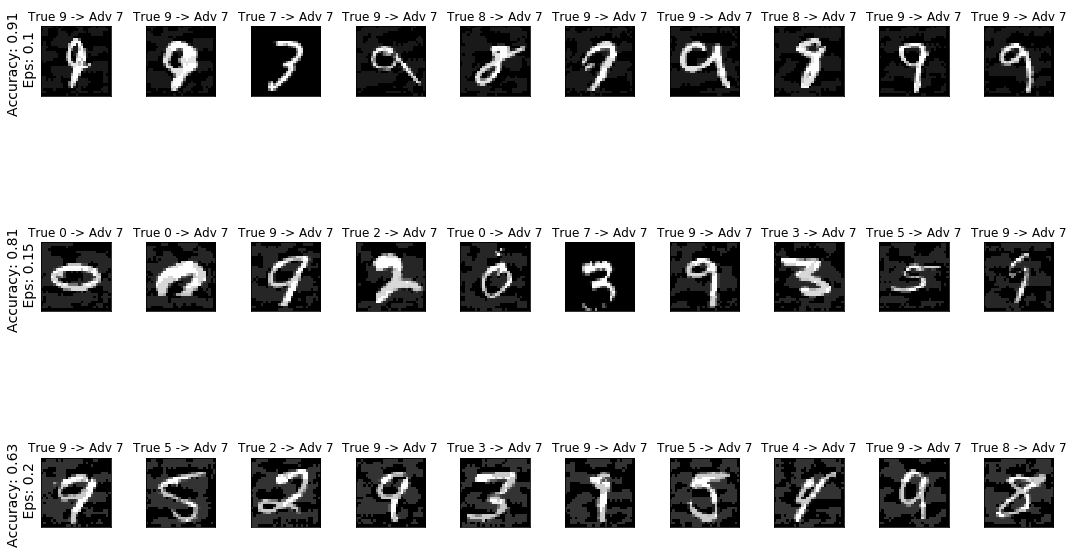

In [177]:
cnt = 0
plt.figure(figsize=(15,90))
for i in range(21, 24):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

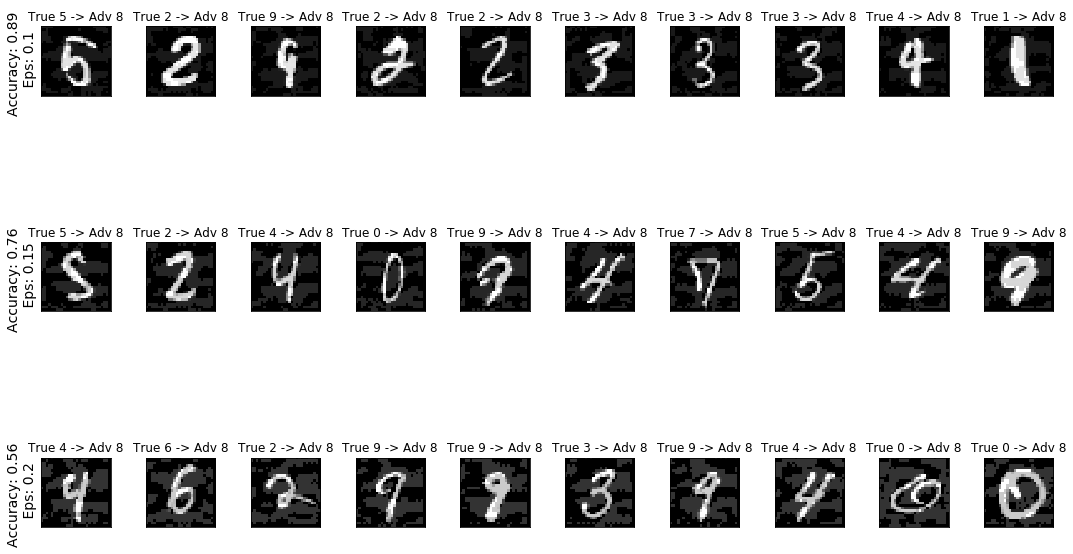

In [178]:
cnt = 0
plt.figure(figsize=(15,90))
for i in range(24, 27):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()

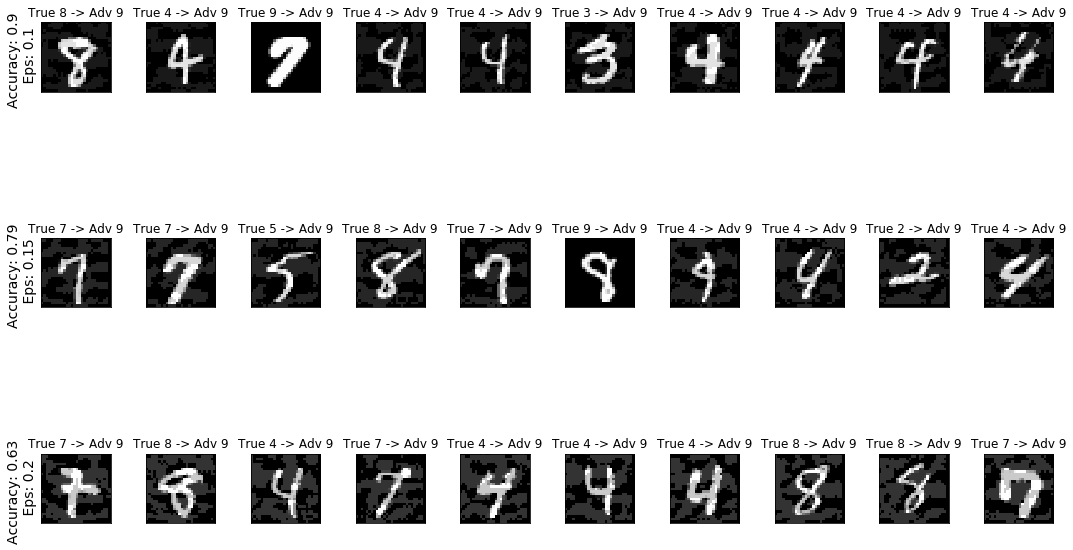

In [179]:
cnt = 0
plt.figure(figsize=(15,90))
for i in range(27, 30):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Accuracy: {} \n Eps: {}".format(round(accuracy[i], 2), epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("True {} -> Adv {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        
plt.tight_layout()
plt.show()